In [1]:
import os
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import random
import numpy as np

np.random.seed(42)

In [2]:
TRAIN = True
# Number of epochs to train for.
EPOCHS = 175



The dataset is structured in the following manner:

```
├── data.yaml
├── README.dataset.txt
├── README.roboflow.txt
├── test
│   ├── images
│   └── labels
├── train
│   ├── images
│   └── labels
└── valid
    ├── images
    └── labels

```

In [3]:
class_names = ['employee_tag']
colors = np.random.uniform(0, 255, size=(len(class_names), 3))

In [4]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [5]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # denormalize the coordinates
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)
        width = xmax - xmin
        height = ymax - ymin
        
        class_name = class_names[int(labels[box_num])]
        
        cv2.rectangle(
            image, 
            (xmin, ymin), (xmax, ymax),
            color=colors[class_names.index(class_name)],
            thickness=2
        ) 

        font_scale = min(1,max(3,int(w/500)))
        font_thickness = min(2, max(10,int(w/50)))
        
        p1, p2 = (int(xmin), int(ymin)), (int(xmax), int(ymax))
        # Text width and height
        tw, th = cv2.getTextSize(
            class_name, 
            0, fontScale=font_scale, thickness=font_thickness
        )[0]
        p2 = p1[0] + tw, p1[1] + -th - 10
        cv2.rectangle(
            image, 
            p1, p2,
            color=colors[class_names.index(class_name)],
            thickness=-1,
        )
        cv2.putText(
            image, 
            class_name,
            (xmin+1, ymin-10),
            cv2.FONT_HERSHEY_SIMPLEX,
            font_scale,
            (255, 255, 255),
            font_thickness
        )
    return image

In [6]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_training_images = glob.glob(image_paths)
    all_training_labels = glob.glob(label_paths)
    all_training_images.sort()
    all_training_labels.sort()
    
    num_images = len(all_training_images)
    
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image = cv2.imread(all_training_images[j])
        with open(all_training_labels[j], 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=0)
    plt.tight_layout()
    plt.show()

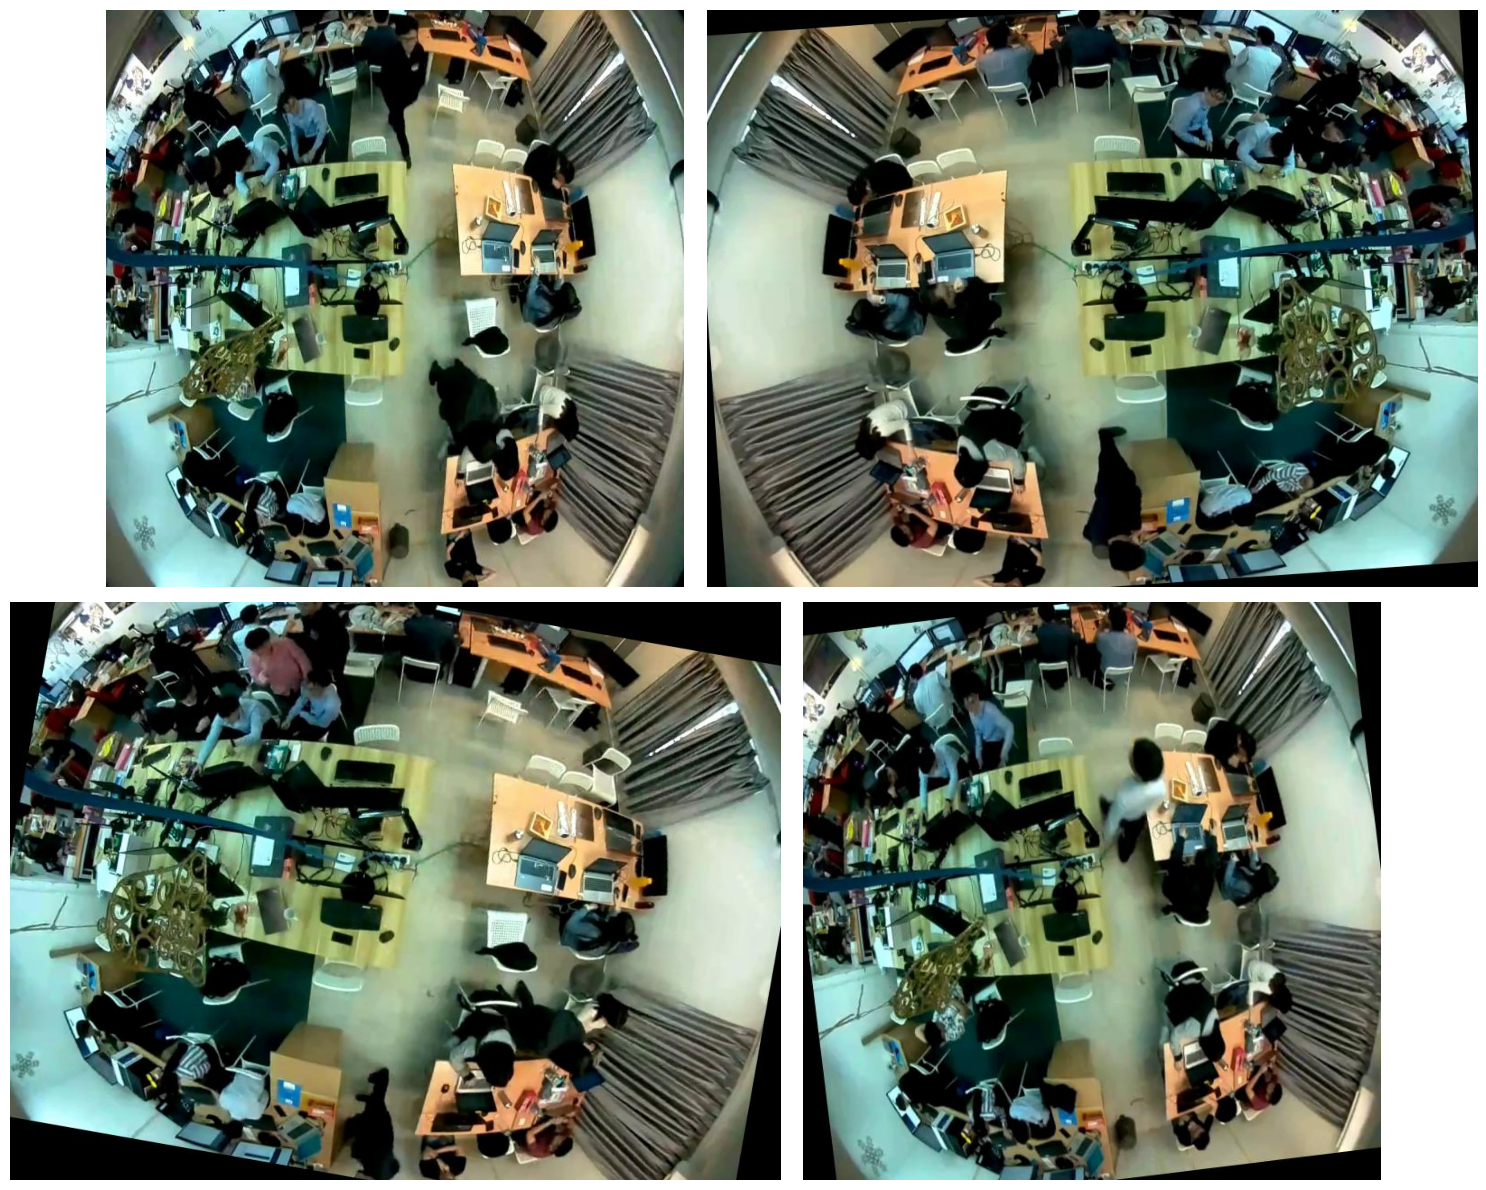

In [7]:
# Visualize a few training images.
plot(
    image_paths='train/images/*', 
    label_paths='train/labels/*',
    num_samples=4,
)

## Helper Functions for Logging

Here, we write the helper functions that we need for logging of the results in the notebook while training the models.

Let's create our custom result directories so that we can easily keep track of them and carry out inference using the proper model.

In [8]:
def set_res_dir():
    # Directory to store results
    res_dir_count = len(glob.glob('runs/train/*'))
    print(f"Current number of result directories: {res_dir_count}")
    if TRAIN:
        RES_DIR = f"results_{res_dir_count+1}"
        print(RES_DIR)
    else:
        RES_DIR = f"results_{res_dir_count}"
    return RES_DIR

**Function to Monitor TensorBoard logs**.

In [9]:
def monitor_tensorboard():
    %load_ext tensorboard
    %tensorboard --logdir runs/train

## Clone YOLOV5 Repository

In [10]:
if not os.path.exists('yolov5'):
    !git clone https://github.com/ultralytics/yolov5.git

In [11]:
%cd yolov5/
!cd

C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\yolov5
C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\yolov5


In [12]:
!pip install -r requirements.txt

In [13]:
monitor_tensorboard()



Reusing TensorBoard on port 6006 (pid 1064), started 6:06:07 ago. (Use '!kill 1064' to kill it.)

In [14]:
from yolov5.train import run

run(data='../data.yaml' , weights='yolov5s.pt', img=640, epochs=EPOCHS, batch_size=16 , name=set_res_dir(), optimizer = 'AdamW')



wandb: WARNING  wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.


wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results


wandb: Enter your choice: (30 second timeout) 3


wandb: You chose "Don't visualize my results"
train: weights=yolov5s.pt, cfg=, data=../data.yaml, hyp=data\hyps\hyp.scratch-low.yaml, epochs=175, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=data\hyps, resume_evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=AdamW, sync_bn=False, workers=8, project=runs\train, name=results_7, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest, ndjson_console=False, ndjson_file=False, img=640


Current number of result directories: 6
results_7


github: up to date with https://github.com/ultralytics/yolov5 
YOLOv5  v7.0-287-g574331f9 Python-3.11.5 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, degrees=0.0, translate=0.1, scale=0.5, shear=0.0, perspective=0.0, flipud=0.0, fliplr=0.5, mosaic=1.0, mixup=0.0, copy_paste=0.0
Comet: run 'pip install comet_ml' to automatically track and visualize YOLOv5  runs in Comet
TensorBoard: Start with 'tensorboard --logdir runs\train', view at http://localhost:6006/
Overriding model.yaml nc=80 with nc=1

                 from  n    params  module                                  arguments                     
  0                -1  1      3520  models.common.Conv                      [3, 32, 6, 2, 2]              
  1          

      6/174      4.71G    0.02583   0.001551          0          4        640: 100%|██████████| 349/349 [00:44<00:00,  7.90it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.05it/s]
                   all        669         75    0.00141      0.933     0.0036    0.00126

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      7/174      4.71G    0.02485   0.001473          0          0        640: 100%|██████████| 349/349 [00:45<00:00,  7.74it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.11it/s]
                   all        669         75    0.00196      0.947     0.0097    0.00278

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
      8/174      4.71G    0.02342   0.001474          0          0        640: 100%|██████████| 349/349 [00:42<00:00,  8.21it/s]
 

     25/174      4.71G    0.01954  0.0008739          0          1        640: 100%|██████████| 349/349 [00:45<00:00,  7.73it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.09it/s]
                   all        669         75      0.692       0.76       0.77      0.316

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     26/174      4.71G     0.0181  0.0008532          0          1        640: 100%|██████████| 349/349 [00:45<00:00,  7.71it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  5.86it/s]
                   all        669         75      0.826      0.693      0.784      0.389

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     27/174      4.71G    0.01852     0.0008          0          2        640: 100%|██████████| 349/349 [00:45<00:00,  7.66it/s]
 

     44/174      4.71G    0.01726   0.000749          0          4        640: 100%|██████████| 349/349 [00:45<00:00,  7.70it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.16it/s]
                   all        669         75      0.791      0.607       0.73      0.414

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     45/174      4.71G    0.01796  0.0007465          0          2        640: 100%|██████████| 349/349 [00:42<00:00,  8.20it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.15it/s]
                   all        669         75      0.691      0.667      0.729      0.435

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     46/174      4.71G    0.01634  0.0007063          0          2        640: 100%|██████████| 349/349 [00:44<00:00,  7.90it/s]
 

     63/174      4.71G    0.01621  0.0005876          0          4        640: 100%|██████████| 349/349 [00:41<00:00,  8.35it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.42it/s]
                   all        669         75      0.753       0.88      0.826       0.49

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     64/174      4.71G    0.01641  0.0006323          0          2        640: 100%|██████████| 349/349 [00:41<00:00,  8.38it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.37it/s]
                   all        669         75       0.73      0.747      0.811      0.444

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     65/174      4.71G    0.01611   0.000611          0          3        640: 100%|██████████| 349/349 [00:41<00:00,  8.34it/s]
 

     82/174      4.71G    0.01524  0.0005395          0          3        640: 100%|██████████| 349/349 [00:41<00:00,  8.36it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.26it/s]
                   all        669         75      0.769       0.88       0.88      0.551

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     83/174      4.71G    0.01467   0.000564          0          5        640: 100%|██████████| 349/349 [00:41<00:00,  8.35it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.35it/s]
                   all        669         75       0.72      0.928      0.848      0.488

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
     84/174      4.71G    0.01519  0.0005424          0          1        640: 100%|██████████| 349/349 [00:41<00:00,  8.32it/s]
 

    101/174      4.71G    0.01457  0.0004765          0          1        640: 100%|██████████| 349/349 [00:41<00:00,  8.38it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.40it/s]
                   all        669         75      0.761       0.92      0.865      0.546

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    102/174      4.71G    0.01402  0.0005027          0          0        640: 100%|██████████| 349/349 [00:41<00:00,  8.39it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.44it/s]
                   all        669         75      0.755      0.933      0.863       0.53

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    103/174      4.71G    0.01429  0.0005136          0          3        640: 100%|██████████| 349/349 [00:41<00:00,  8.40it/s]
 


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    120/174      4.71G    0.01315   0.000502          0          1        640: 100%|██████████| 349/349 [00:42<00:00,  8.30it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.34it/s]
                   all        669         75      0.751      0.947      0.874      0.552

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    121/174      4.71G    0.01332  0.0004865          0          1        640: 100%|██████████| 349/349 [00:41<00:00,  8.33it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.57it/s]
                   all        669         75      0.756      0.947      0.885      0.557

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    122/174      4.71G    0.01282  0.0004849       


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    139/174      4.71G    0.01217   0.000442          0          4        640: 100%|██████████| 349/349 [00:43<00:00,  8.03it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.53it/s]
                   all        669         75      0.758      0.962      0.899      0.576

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    140/174      4.71G    0.01258  0.0004504          0          3        640: 100%|██████████| 349/349 [00:42<00:00,  8.14it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.59it/s]
                   all        669         75      0.768      0.971        0.9      0.576

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    141/174      4.71G    0.01211  0.0004471       


      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    158/174      4.71G    0.01091  0.0004203          0          6        640: 100%|██████████| 349/349 [00:43<00:00,  8.05it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.30it/s]
                   all        669         75      0.768       0.96      0.878       0.57

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    159/174      4.71G    0.01165   0.000444          0          2        640: 100%|██████████| 349/349 [00:43<00:00,  8.02it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 21/21 [00:03<00:00,  6.25it/s]
                   all        669         75      0.768       0.96      0.878      0.572

      Epoch    GPU_mem   box_loss   obj_loss   cls_loss  Instances       Size
    160/174      4.71G    0.01106  0.0004031       

Namespace(weights='yolov5s.pt', cfg='', data='../data.yaml', hyp={'lr0': 0.01, 'lrf': 0.01, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'warmup_bias_lr': 0.1, 'box': 0.05, 'cls': 0.5, 'cls_pw': 1.0, 'obj': 1.0, 'obj_pw': 1.0, 'iou_t': 0.2, 'anchor_t': 4.0, 'fl_gamma': 0.0, 'hsv_h': 0.015, 'hsv_s': 0.7, 'hsv_v': 0.4, 'degrees': 0.0, 'translate': 0.1, 'scale': 0.5, 'shear': 0.0, 'perspective': 0.0, 'flipud': 0.0, 'fliplr': 0.5, 'mosaic': 1.0, 'mixup': 0.0, 'copy_paste': 0.0}, epochs=175, batch_size=16, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, evolve_population=WindowsPath('data/hyps'), resume_evolve=None, bucket='', cache=None, image_weights=False, device='', multi_scale=False, single_cls=False, optimizer='AdamW', sync_bn=False, workers=8, project='runs\\train', name='results_7', exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_p

In [28]:
RES_DIR = 'results_7'

In [35]:
from detect import run
# Helper function for inference on images.
def inference(RES_DIR, data_path):
    # Directory to store inference results.
    infer_dir_count = len(glob.glob('runs\\detect\\*'))
    INFER_DIR = f"inference_{infer_dir_count+1}"
    print(INFER_DIR)
    # Run inference on images and videos
    run(weights = f"runs\\train\\{RES_DIR}\\weights\\best.pt", source = data_path, name = INFER_DIR, save_txt = True, save_conf = True, conf_thres=0.5)
    return INFER_DIR

In [31]:
def visualize(INFER_DIR):
# Visualize inference images.
    INFER_PATH = f"runs\\detect\\{INFER_DIR}"
    infer_images = glob.glob(f"{INFER_PATH}\\*.jpg")
    print(infer_images)
    for pred_image in infer_images:
        image = cv2.imread(pred_image)
        plt.figure(figsize=(19, 16))
        plt.imshow(image[:, :, ::-1])
        plt.axis('off')
        plt.show()

In [ ]:
def extract_frame_number_and_coordinates(INFER_DIR):
    # Extract frame number from the file name
    file_name = os.path.basename(yolo_txt_file)
    frame_number = int(file_name.split('_')[1].split('.')[0])

    # Initialize list to store coordinates
    coordinates = []

    # Read lines from YOLOv5 text file
    with open(yolo_txt_file, 'r') as file:
        lines = file.readlines()

    # Extract XY coordinates from each line
    for line in lines:
        data = line.strip().split()
        x_center, y_center, width, height = map(float, data[1:])
        # Calculate XY coordinates of the bounding box
        x1 = int((x_center - width / 2) * image_width)
        y1 = int((y_center - height / 2) * image_height)
        x2 = int((x_center + width / 2) * image_width)
        y2 = int((y_center + height / 2) * image_height)
        coordinates.append((x1, y1, x2, y2))

    return frame_number, coordinates

In [32]:
%cd yolov5

[WinError 2] The system cannot find the file specified: 'yolov5'
C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\yolov5


In [33]:
show_valid_results(RES_DIR)

results_7
['runs\\train\\results_7\\val_batch0_pred.jpg', 'runs\\train\\results_7\\val_batch1_pred.jpg', 'runs\\train\\results_7\\val_batch2_pred.jpg']


In [36]:
IMAGE_INFER_DIR = inference(RES_DIR, '..\\inferenceImages')

YOLOv5  v7.0-287-g574331f9 Python-3.11.5 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)

Fusing layers... 


Current number of inference detection directories: 13
inference_14


Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_000384_PNG.rf.90c8fb3c3c5ceb8f5f1c3629f9139e12.jpg: 480x640 1 employee_tag, 8.0ms
image 2/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_000384_PNG.rf.b54b66488063d1a537f8eb8a0b4c20ad.jpg: 640x640 1 employee_tag, 10.0ms
image 3/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_000431_PNG.rf.ce2b91714e1e519f1f6a07ef7ac05c59.jpg: 640x640 1 employee_tag, 8.0ms
image 4/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_000431_PNG.rf.fbc67dc7fa7e30d8b862897e508650c7.jpg: 480x640 1 employee_tag, 9.0ms
image 5/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_000460_PNG.rf.6eb0d82b0b14cfee7545b6983aca9045.jpg: 480x640 1 employee_tag, 7.0ms
image 6/75 C:\Users\yewyn\Documents\footfa

image 47/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_001012_PNG.rf.4189bd1f3dba753518749eff946d231b.jpg: 640x640 1 employee_tag, 8.0ms
image 48/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_001015_PNG.rf.85ae535387bab19fb2a1f66b60ded973.jpg: 640x640 1 employee_tag, 7.0ms
image 49/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_001015_PNG.rf.fc8100f7c45f1ccdc3588c44c8444708.jpg: 480x640 1 employee_tag, 11.0ms
image 50/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_001022_PNG.rf.3cf9c5638081ebfb4b55dd2f8adb0e54.jpg: 640x640 1 employee_tag, 9.0ms
image 51/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_001022_PNG.rf.a697430e863980038a40cd13595714b6.jpg: 480x640 1 employee_tag, 7.0ms
image 52/75 C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\inferenceImages\frame_001025_PNG.rf

In [37]:
VIDEO_INFER_DIR = inference(RES_DIR, '..\\sample.mp4')

YOLOv5  v7.0-287-g574331f9 Python-3.11.5 torch-2.2.1 CUDA:0 (NVIDIA GeForce RTX 3060 Ti, 8192MiB)

Fusing layers... 


Current number of inference detection directories: 14
inference_15


Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
video 1/1 (1/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (2/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (3/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (4/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (5/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (6/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (7/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (8/1341) C:\Users\yewyn\Documents\footfall_task\tr

video 1/1 (67/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 9.0ms
video 1/1 (68/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (69/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (70/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.5ms
video 1/1 (71/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (72/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (73/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (74/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms


video 1/1 (133/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (134/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (135/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (136/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (137/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (138/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (139/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (140/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (199/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (200/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (201/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (202/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (203/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (204/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (205/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (206/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (265/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (266/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (267/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (268/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (269/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (270/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (271/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (272/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (331/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (332/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (333/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (334/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (335/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (336/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (337/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (338/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (397/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (398/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (399/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (400/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (401/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 9.0ms
video 1/1 (402/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (403/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (404/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (463/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 6.0ms
video 1/1 (464/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (465/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (466/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (467/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (468/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (469/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 6.0ms
video 1/1 (470/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms


video 1/1 (529/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (530/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (531/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (532/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (533/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (534/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (535/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (536/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (595/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (596/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (597/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (598/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (599/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (600/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (601/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (602/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (661/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (662/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (663/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (664/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (665/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (666/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (667/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (668/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (727/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (728/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (729/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (730/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (731/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (732/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (733/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 9.0ms
video 1/1 (734/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (793/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (794/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (795/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (796/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (797/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 10.0ms
video 1/1 (798/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (799/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (800/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections

video 1/1 (859/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 9.0ms
video 1/1 (860/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 8.0ms
video 1/1 (861/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 8.0ms
video 1/1 (862/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 8.0ms
video 1/1 (863/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 8.0ms
video 1/1 (864/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 9.0ms
video 1/1 (865/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 9.0ms
video 1/1 (866/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 9.0m

video 1/1 (925/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (926/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (927/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 8.0ms
video 1/1 (928/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 6.0ms
video 1/1 (929/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 6.0ms
video 1/1 (930/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (931/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (932/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms

video 1/1 (991/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (992/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (993/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (994/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (995/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (996/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (997/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (998/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections)

video 1/1 (1056/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1057/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1058/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1059/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (1060/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (1061/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (1062/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (1063/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_

video 1/1 (1121/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1122/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 7.0ms
video 1/1 (1123/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1124/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1125/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1126/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1127/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1128/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no dete

video 1/1 (1186/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1187/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1188/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1189/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1190/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1191/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1192/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1193/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no det

video 1/1 (1251/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 1 employee_tag, 6.0ms
video 1/1 (1252/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (1253/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1254/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1255/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1256/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1257/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1258/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no dete

video 1/1 (1316/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1317/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 6.0ms
video 1/1 (1318/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1319/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 8.0ms
video 1/1 (1320/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1321/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1322/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no detections), 7.0ms
video 1/1 (1323/1341) C:\Users\yewyn\Documents\footfall_task\training_data_roboflow\sample.mp4: 480x640 (no det